In [64]:
import numpy as np
import pandas as pd
import seaborn as sns

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt


# Load data

In [86]:
data_file = 'data/house.csv'
housing = pd.read_csv(data_file)

According to the task, only some columns of the dataset are to be used

In [87]:
valid_columns = ['id', 'date', 'price', 'price_bin',
                 'bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront',
                'view', 'condition', 'grade', 
                'sqft_above', 'sqft_basement', 'yr_built',
                'lat', 'long']
# For data exploration, lat and long will also be used

housing = housing[valid_columns]

# First look at the data

In [66]:
housing.describe()

,id,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.401822e+05,0.067783,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,...,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.673622e+05,0.251379,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,...,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,0.000000,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,0.000000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,0.000000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,1.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [67]:
housing.head()

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,0,3,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,0,3,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,0,2,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,0,4,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,0,3,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [62]:
housing[housing['bathrooms'] % 1 != 0]

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,2014-12-09,538000.0,0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5,2014-05-12,1230000.0,1,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,2014-06-27,257500.0,0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2015-01-15,291850.0,0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
9,2015-03-12,323000.0,0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2014-05-21,360000.0,0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,2015-02-23,400000.0,0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,2014-06-23,402101.0,0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,2015-01-16,400000.0,0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [80]:
housing[housing['floors'] % 1 != 0]

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
12,2014-05-28,310000.0,0,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927
14,2015-03-12,530000.0,0,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900
17,2014-05-29,485000.0,0,4,1.00,1600,4300,1.5,0,0,4,7,1600,0,1916
25,2014-11-03,233000.0,0,3,2.00,1710,4697,1.5,0,0,5,6,1710,0,1941
27,2014-12-01,667000.0,0,3,1.00,1400,1581,1.5,0,0,5,8,1400,0,1909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21345,2014-06-12,680000.0,0,3,2.50,2570,3600,2.5,0,0,3,9,2570,0,2007
21386,2015-04-17,320000.0,0,3,1.75,1790,66250,1.5,0,0,3,7,1790,0,2003
21457,2014-10-14,669950.0,0,3,3.00,2330,1944,2.5,0,0,3,8,1950,380,2014
21502,2014-08-01,453000.0,0,3,2.50,1510,1618,2.5,0,0,3,8,1330,180,2011


For now, we can assume that the 0.75 bathroom is a bathroom without a shower/bathtub, and that the 'uneven' floors are non-standard, e.g. the attic. 

In a real project, this would be a great moment to ask about this kind of issues.

Let's also check if we have any NaNs in our data set.

In [79]:
housing.isnull().values.any()

False

No NaNs, great!

# Preliminary cleaning

Since the 'id' column does not provide us with any additional information, we will also get rid of it

In [69]:
housing.drop(['id'], axis=1, inplace=True)

The 'date' column could be much nicer, lets go ahead and do that:

In [70]:
housing['date'] = pd.to_datetime(housing['date'])

In [71]:
housing.head()

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
0,2014-10-13,221900.0,0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955
1,2014-12-09,538000.0,0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951
2,2015-02-25,180000.0,0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933
3,2014-12-09,604000.0,0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965
4,2015-02-18,510000.0,0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987


Already looking a bit better, lets now take a look at the distributions. This is not a very big data and we do not have too many features. Thus, we have chance to plot most of them and reach some useful analytical results. 

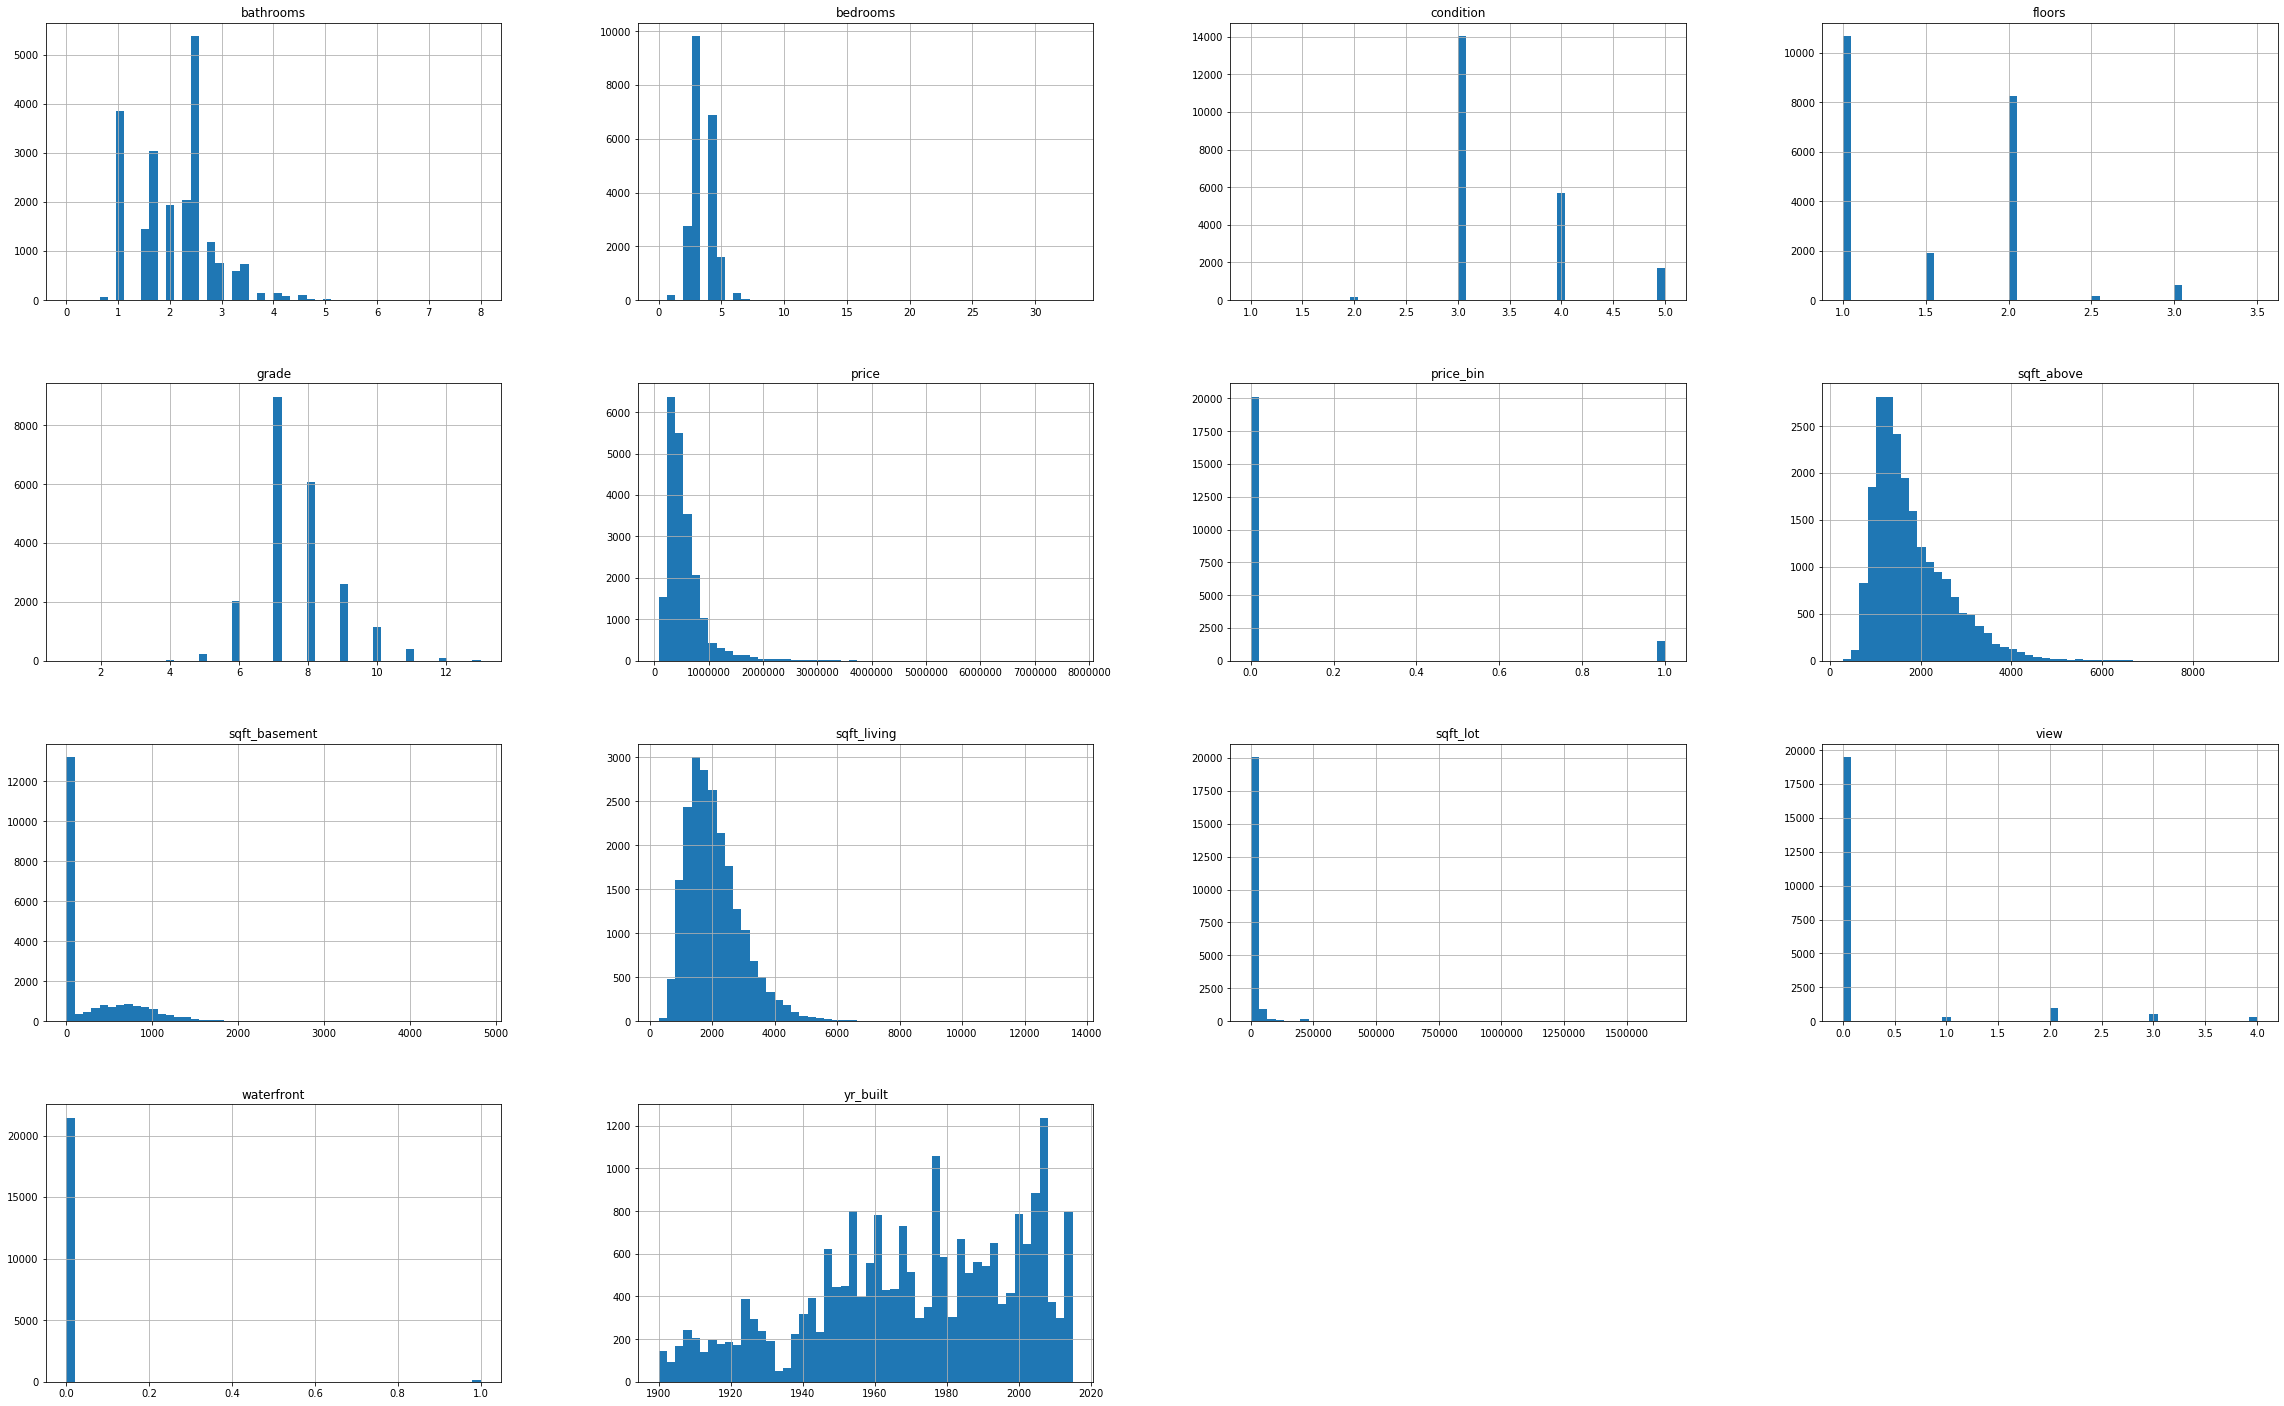

In [72]:
ax = housing.hist(bins=50, figsize=(40, 25))

We can already see some possible problems with this dataset - especially with bedrooms, price and sqft_lot, sqft_lot15, which have a very long-tailed distribution, indicating several outliers. This might be pesky to deal with later, so we will try to clean it up before creating a model

Let's see what we can do with the bedrooms first.

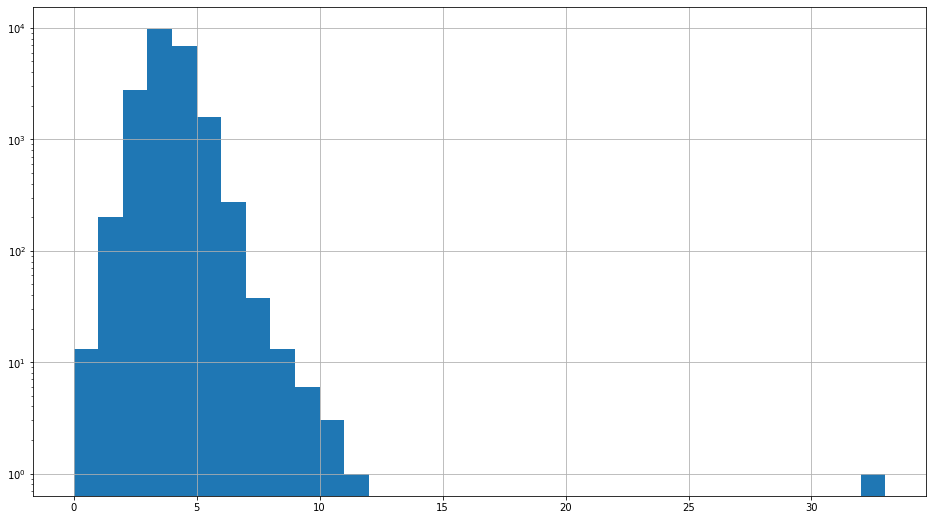

In [33]:
# Histogram with logarythmic scale to better visualize the outlier
housing['bedrooms'].hist(bins=33, log=True, figsize=(16, 9))

In [34]:
counts = housing['bedrooms'].value_counts(ascending=True)
print(counts)

33       1
11       1
10       3
9        6
0       13
8       13
7       38
1      199
6      272
5     1601
2     2760
4     6882
3     9824
Name: bedrooms, dtype: int64


As suspected, we have the most data in the 1-6 bedroom range, with several outliers - one of the houses has 33 bedrooms, and some of them have none (!).

In [35]:
bedroom_outlier = housing.loc[(housing['bedrooms'] > 6) | (housing['bedrooms'] == 0)]
bedroom_outlier.head()

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
556,2014-06-20,1950000.0,1,7,3.5,4640,15235,2.0,0,1,...,11,2860,1780,1965,2003,98040,47.5666,-122.231,3230,20697
875,2014-06-12,1100000.0,1,0,0.0,3064,4764,3.5,0,2,...,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
1135,2015-01-05,420000.0,0,7,3.0,2940,8624,1.0,0,0,...,8,1690,1250,1977,0,98155,47.7555,-122.307,1850,8031
1241,2014-06-23,350000.0,0,7,3.0,2800,9569,1.0,0,2,...,7,1400,1400,1963,0,98056,47.5102,-122.183,2150,7333
1660,2014-12-04,490000.0,0,8,5.0,2800,2580,2.0,0,0,...,8,1880,920,1997,0,98122,47.6086,-122.303,1800,2580


In [36]:
bedroom_outlier.describe()

,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,7.500000e+01,75.000000,75.000000,75.000000,75.00000,75.000000,75.000000,75.0,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,8.645055e+05,0.226667,6.640000,3.163333,3480.16000,17237.706667,1.786667,0.0,0.373333,3.346667,7.960000,2737.360000,742.800000,1961.920000,160.186667,98082.400000,47.599492,-122.236853,2220.640000,14636.853333
std,7.003739e+05,0.421495,4.323537,1.684334,1861.82113,42176.862882,0.605009,0.0,0.911982,0.725842,1.796694,1443.312188,814.370193,32.293318,546.884016,48.431339,0.105169,0.131635,855.898084,35292.932515
min,1.399500e+05,0.000000,0.000000,0.000000,290.00000,979.000000,1.000000,0.0,0.000000,1.000000,1.000000,290.000000,0.000000,1901.000000,0.000000,98001.000000,47.278100,-122.491000,1060.000000,1399.000000
25%,4.250000e+05,0.000000,7.000000,2.500000,2600.00000,5000.000000,1.000000,0.0,0.000000,3.000000,7.000000,1870.000000,0.000000,1947.500000,0.000000,98039.500000,47.534400,-122.323000,1550.000000,4405.000000
50%,6.400000e+05,0.000000,7.000000,3.000000,3150.00000,8145.000000,2.000000,0.0,0.000000,3.000000,8.000000,2530.000000,600.000000,1964.000000,0.000000,98103.000000,47.626300,-122.289000,2010.000000,7479.000000
75%,9.430000e+05,0.000000,8.000000,4.000000,4215.00000,12314.000000,2.000000,0.0,0.000000,4.000000,9.000000,3215.000000,1305.000000,1988.500000,0.000000,98117.000000,47.668400,-122.168000,2515.000000,10202.500000
max,3.300000e+06,1.000000,33.000000,8.000000,13540.00000,307752.000000,3.500000,0.0,4.000000,5.000000,12.000000,9410.000000,4130.000000,2013.000000,2013.000000,98199.000000,47.756500,-121.826000,4850.000000,224341.000000


As we have only 75 entries with 'unusual' number of bedrooms, which is ~0.3% of our data, we will just get rid of those records.

In [37]:
housing.drop(housing[(housing['bedrooms'] > 6) | (housing['bedrooms'] == 0)].index, inplace=True)

Let's focus on the price now

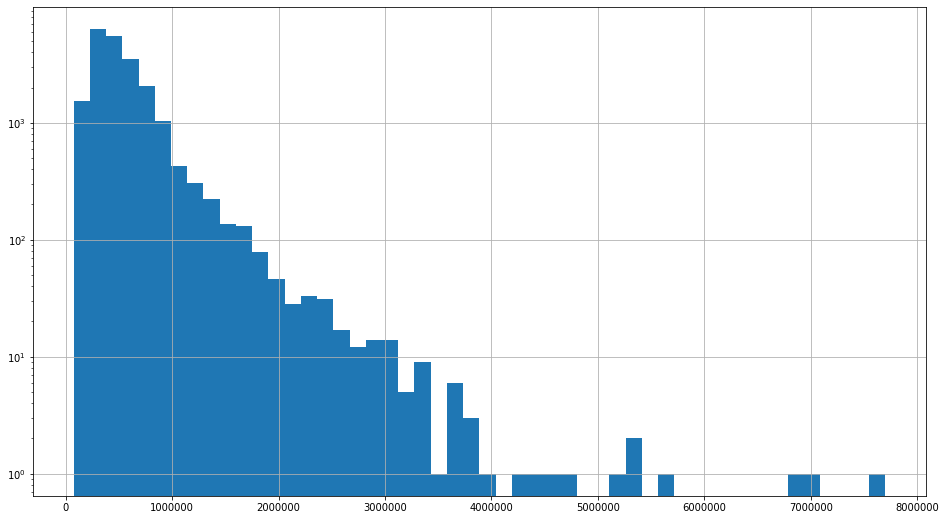

In [38]:
housing['price'].hist(bins=50, log=True, figsize=(16, 9))

In [39]:
price_threshold = 4000000
housing[housing['price'] > price_threshold]

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1164,2014-10-20,5110000.0,1,5,5.25,8010,45517,2.0,1,4,...,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
1315,2015-04-13,5300000.0,1,6,6.00,7390,24829,2.0,1,4,...,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1448,2015-04-13,5350000.0,1,5,5.00,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
2626,2014-08-15,4500000.0,1,5,5.50,6640,40014,2.0,1,4,...,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
3914,2014-06-11,7060000.0,1,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
4411,2014-08-04,5570000.0,1,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
7252,2014-10-13,7700000.0,1,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8092,2014-06-17,4670000.0,1,5,6.75,9640,13068,1.0,1,4,...,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454
8638,2014-06-18,4490000.0,1,4,3.00,6430,27517,2.0,0,0,...,12,6430,0,2001,0,98004,47.6208,-122.219,3720,14592
9254,2014-09-19,6890000.0,1,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


Once again, 11 values represent the upper half of the price range. This raises a question if we will be able to accurately train model for this price range, and would not it be better to delegate this task to an expert, as the cases are rare. Other option is training a separate model, just for the 'high-end'. 

Of course, this would depend on the bussiness requirements - can we deliver predictions just to a certain threshold (e.g. 4kk), or can we compromise on accuracy by serving predictions for the entire price range of the dataset.

For now, the main focus will be on the more moderate price range, and values above the threshold will be disregarded.

In [40]:
housing.drop(housing[(housing['price'] > price_threshold)].index, inplace=True)

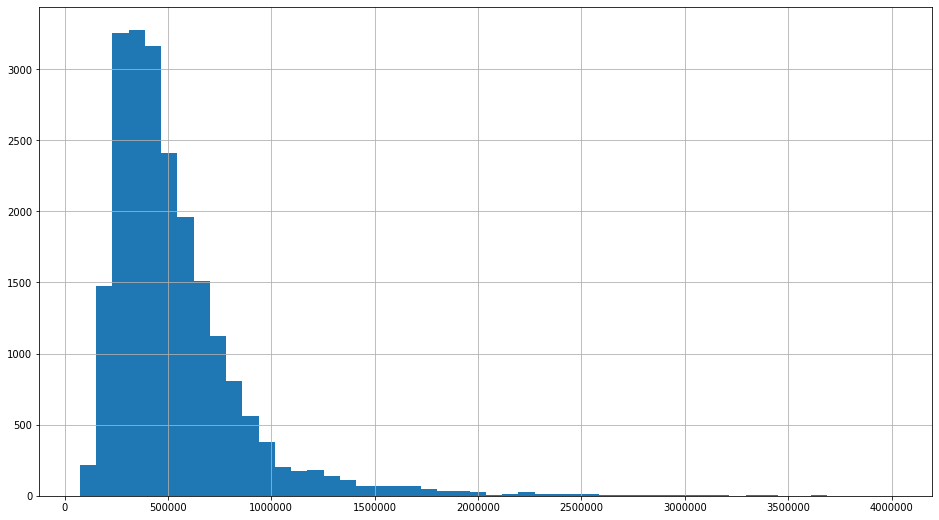

In [41]:
housing['price'].hist(bins=50, figsize=(16, 9))

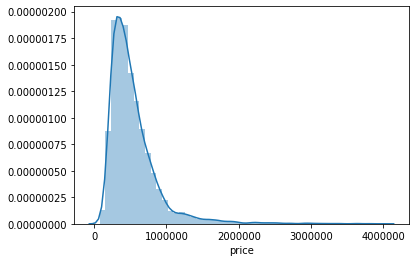

In [42]:
sns.distplot(housing['price'])

Still not perfect, but much better looking than the original distribution. We will see how the served predictions will look like, but it might be worth investigating if we can train model for only price range up to 1kk.

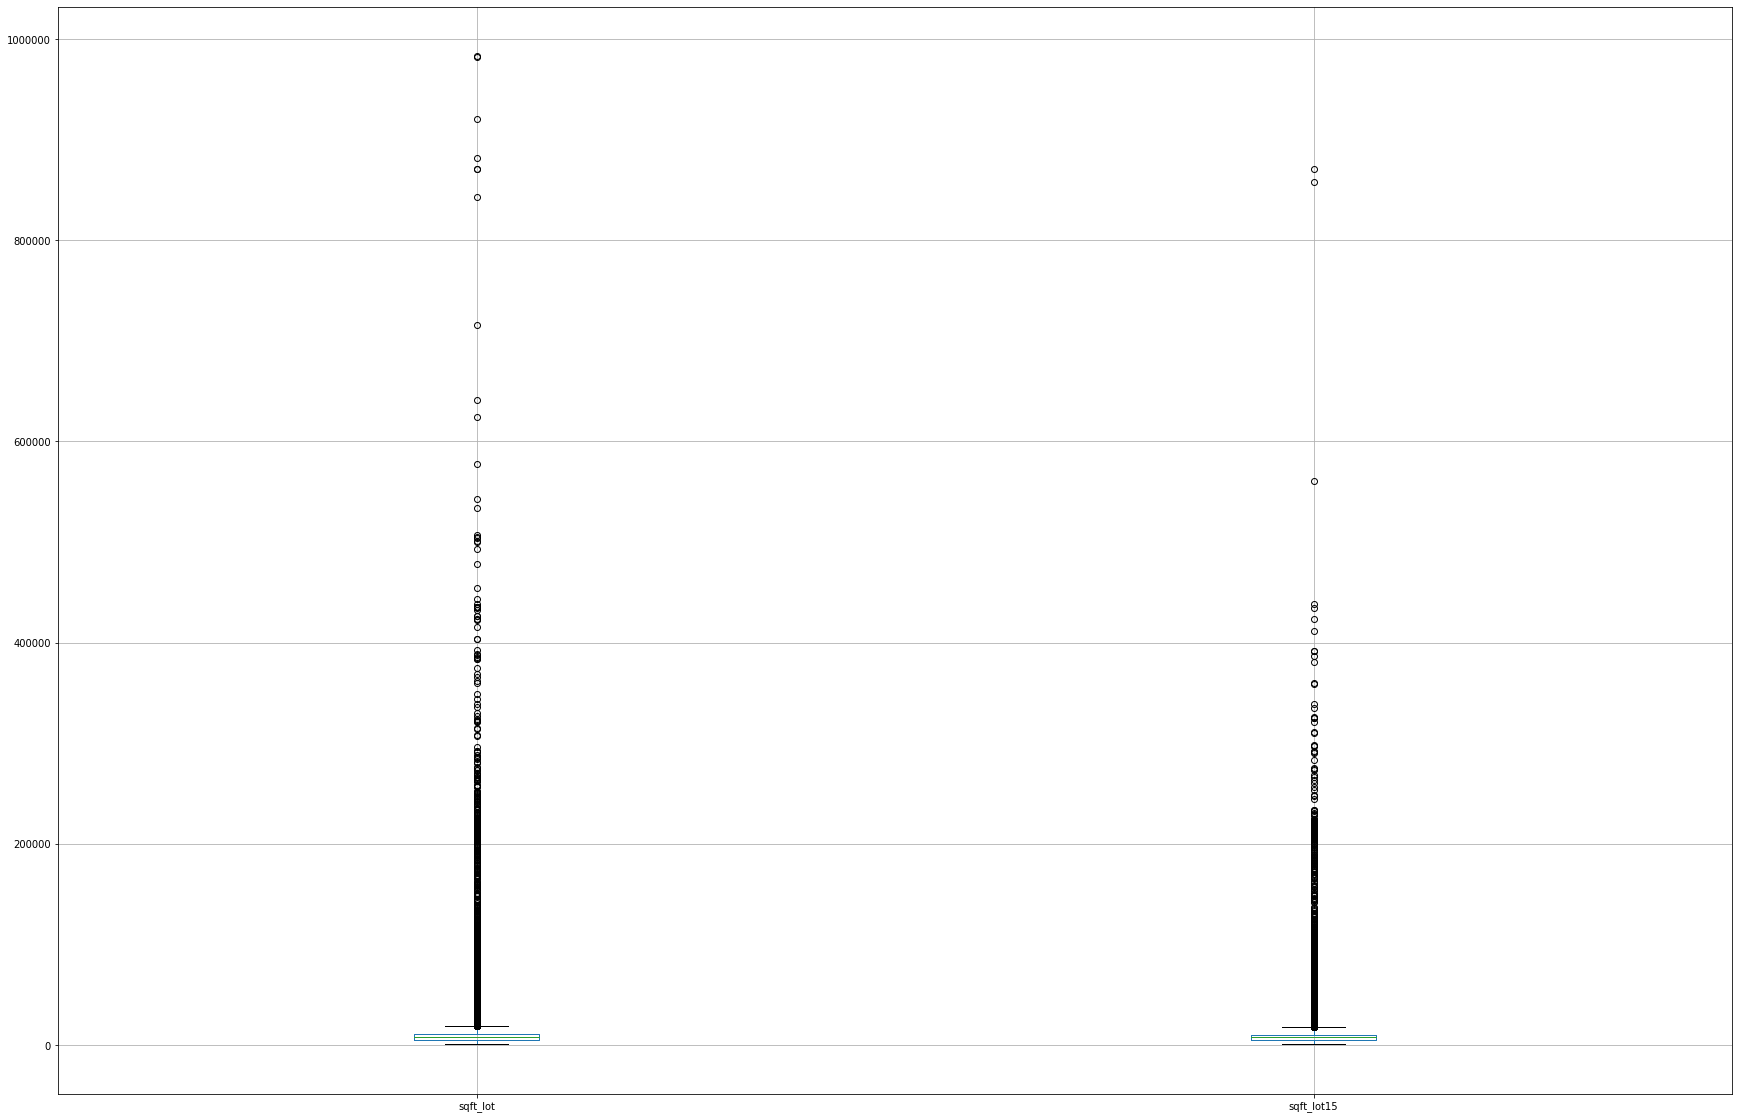

In [55]:
housing.boxplot(column=['sqft_lot', 'sqft_lot15'], figsize=(30, 20))

In [54]:
housing.drop(housing[housing['sqft_lot'] > 1000000].index, inplace=True)

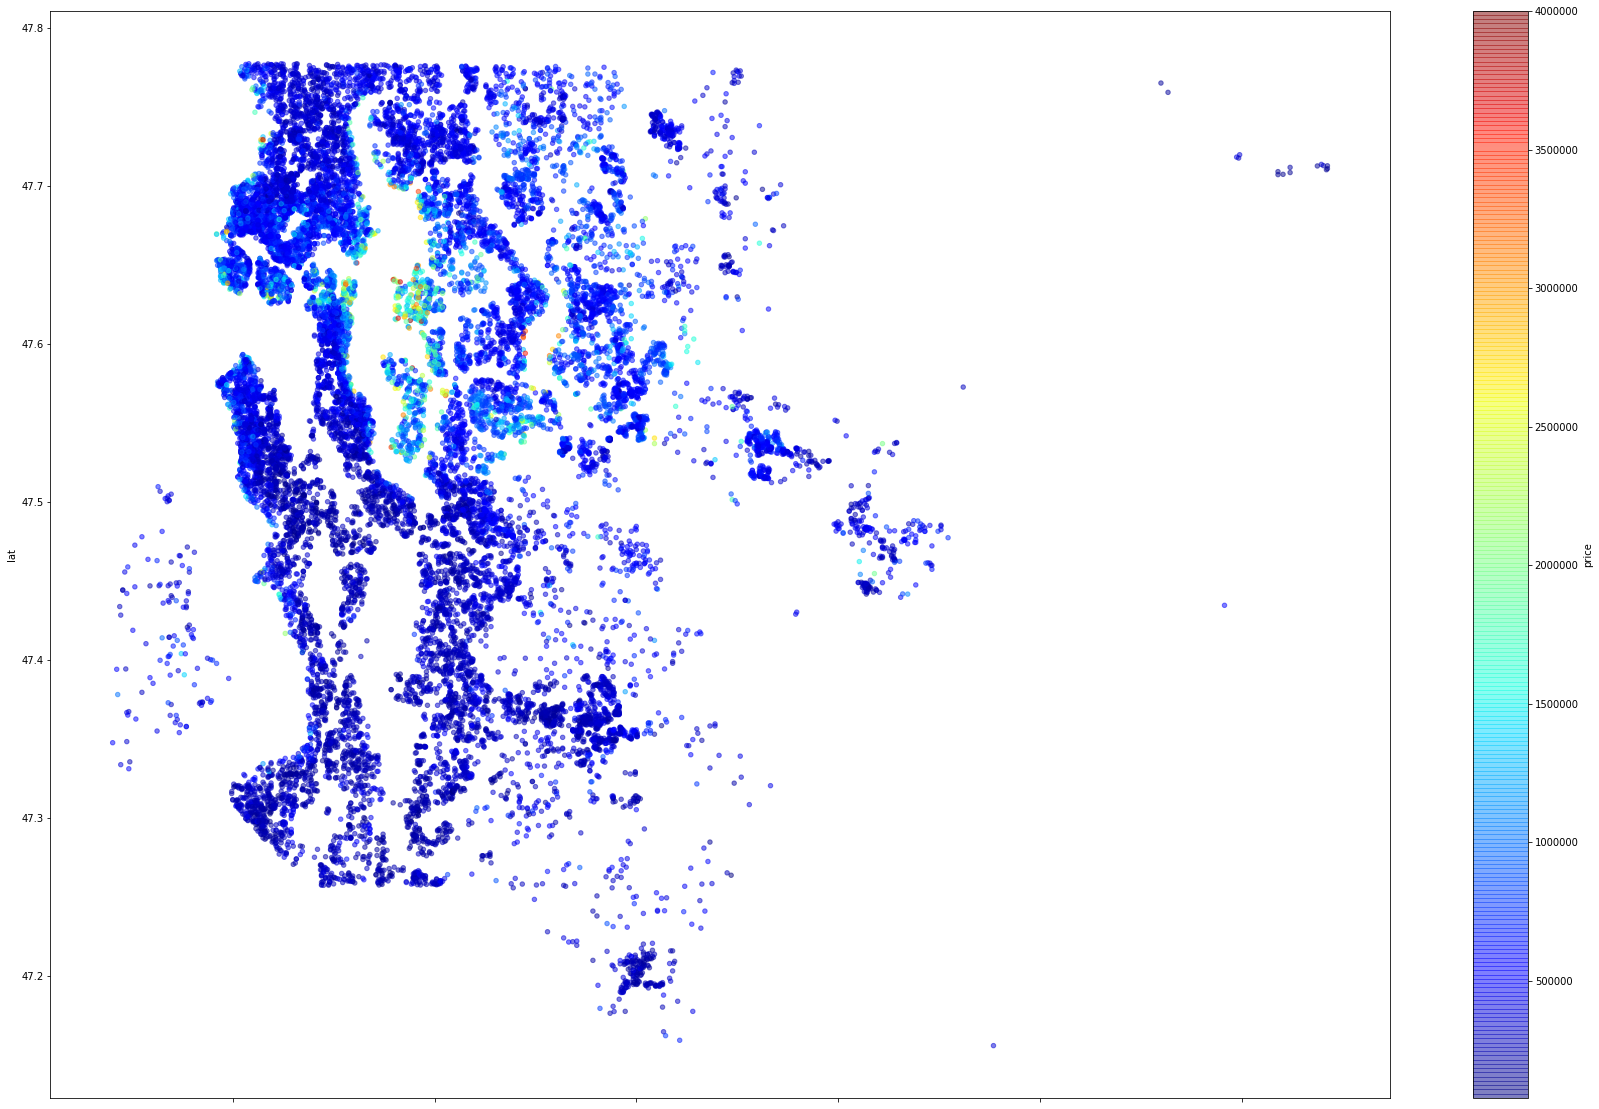

In [44]:
housing.plot(kind='scatter', x='long', y='lat', alpha=0.5,
            c='price', cmap=plt.get_cmap('jet'), colorbar=True, 
            figsize=(30, 20))

In [45]:
correlation_matrix = housing.corr()
correlations = correlation_matrix['price'].sort_values(ascending=False)
print(correlations)

price            1.000000
price_bin        0.745101
sqft_living      0.693862
grade            0.677542
sqft_above       0.596898
sqft_living15    0.596801
bathrooms        0.520492
view             0.397164
lat              0.320661
bedrooms         0.315070
sqft_basement    0.309944
floors           0.261670
waterfront       0.250663
yr_renovated     0.123349
sqft_lot         0.091375
sqft_lot15       0.083975
yr_built         0.057472
condition        0.038818
long             0.025104
zipcode         -0.051345
Name: price, dtype: float64


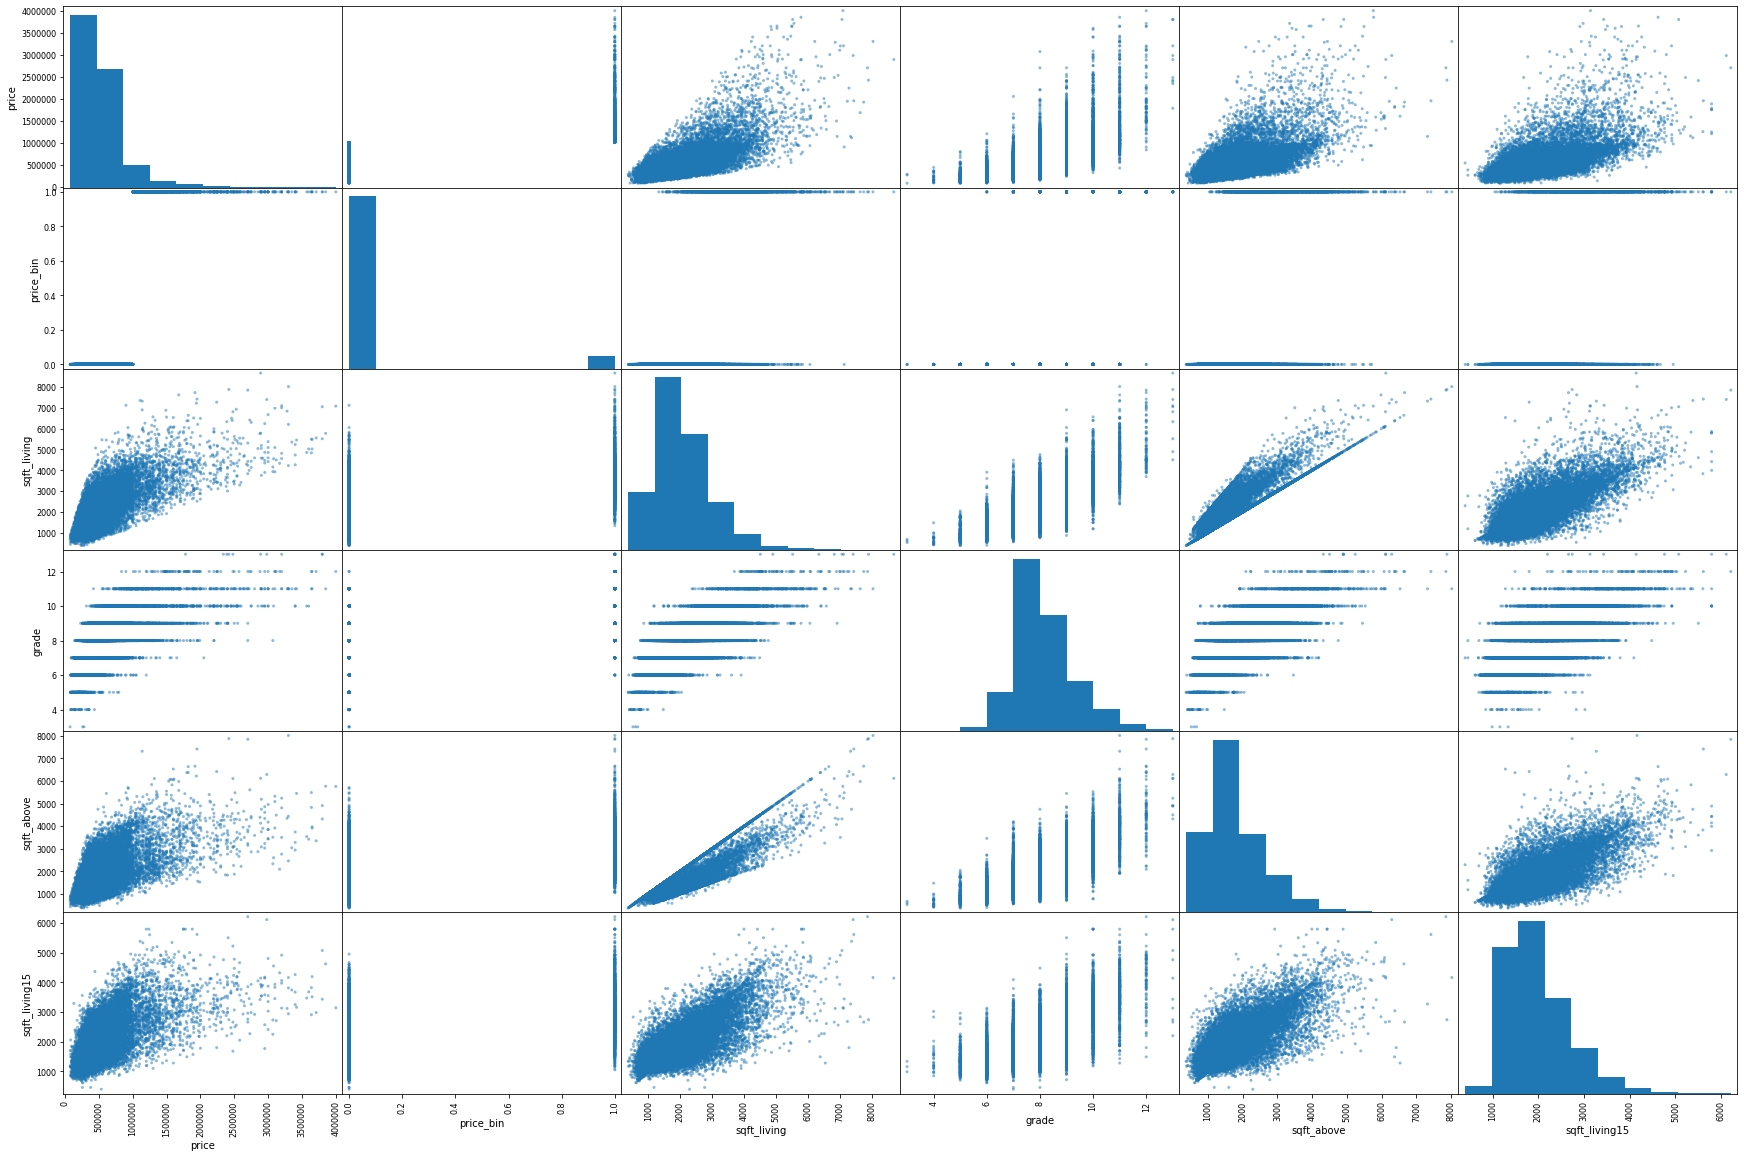

In [56]:
attributes = correlations.index[:6]
ax = pd.plotting.scatter_matrix(housing[attributes], figsize=(30, 20))

At this stage, we can start questioning if the 'grade' column is really the slope of the lot. It has a very high correlation with price, and at the same time, there seems to be no flat lots, with the majority of them having 7-8° (see below), which seems suspicious.

In [90]:
housing['grade'].value_counts()

7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: grade, dtype: int64

Since the data is for King County, WA, this seems to be a better, and more fitting description of grade:
Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc. 
SOURCE: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

This would explain a very high correlation with price much bettar than the lot slope.

In [47]:
print(correlations.index)

Index(['price', 'price_bin', 'sqft_living', 'grade', 'sqft_above',
       'sqft_living15', 'bathrooms', 'view', 'lat', 'bedrooms',
       'sqft_basement', 'floors', 'waterfront', 'yr_renovated', 'sqft_lot',
       'sqft_lot15', 'yr_built', 'condition', 'long', 'zipcode'],
      dtype='object')
